### 1. Выберите наборы данных, которые можно интерпретировать, как временные ряды:

а) зависимость цены на недвижимость в конкретном регионе от времени,

б) скорость полета самолета при перелете из аэропорта А в аэропорт В,

в) количество отказов компьютера,

г) число обращений в поликлинику по району,

д) координаты автобуса при движении по маршруту,

е) координаты фигуры нарушителя в файле видеофиксации охранной системы.

а) Тут присутствует параметр время, так что это временной ряд.
б) Это временной ряд, т.к. из аэропорта А до аэропорта В самолет долетает за какое-то время. На графике на вертикальной оси отметим значение скорости, а по горизонтальной время.
в) и г) Если рассматривать данные за какой-то период и фиксировать значения в измеряемом интервале, то можно интерпритировать это как временные ряды. А так это просто число.
д) Т.к. автобус проезжает маршрут за какое-то время, то можно рассмотреть как временной ряд. На графике будут две кривые изменения координат по широте и долготе.
е) Это временной ряд, т.к. файл видео фиксации идет ограниченное время.

### 2. Прочитайте DUQ_hourly.csv и проверьте качество и порядок разметки этой выборки с информацией о потреблении энергии в одном из районов Восточной Электросети США. Сделайте описание особенностей этой выборки.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd 
import seaborn as sns

from sklearn.metrics import mean_squared_error

Прочтем датасет

In [2]:
data = pd.read_csv('DUQ_hourly.csv', index_col=[0], parse_dates=[0])

Отсортируем данные по индексам для наглядности

In [3]:
data = data.sort_index()

Посмотрим как в целом выглядят данные

In [4]:
data.head()

,DUQ_MW
Datetime,
2005-01-01 01:00:00,1364.0
2005-01-01 02:00:00,1273.0
2005-01-01 03:00:00,1218.0
2005-01-01 04:00:00,1170.0
2005-01-01 05:00:00,1166.0


In [5]:
data.describe()

,DUQ_MW
count,119068.000000
mean,1658.820296
std,301.740640
min,1014.000000
25%,1444.000000
50%,1630.000000
75%,1819.000000
max,3054.000000


Данные имеют целочисленную структуру и небольшие цифры. Изменим тип данных для оптимизации используемой памяти

In [6]:
data['DUQ_MW'] = data['DUQ_MW'].astype('int16')

Видим, что нет пропущенных данных

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 119068 entries, 2005-01-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   DUQ_MW  119068 non-null  int16
dtypes: int16(1)
memory usage: 1.1 MB


Text(0, 0.5, 'МВт')

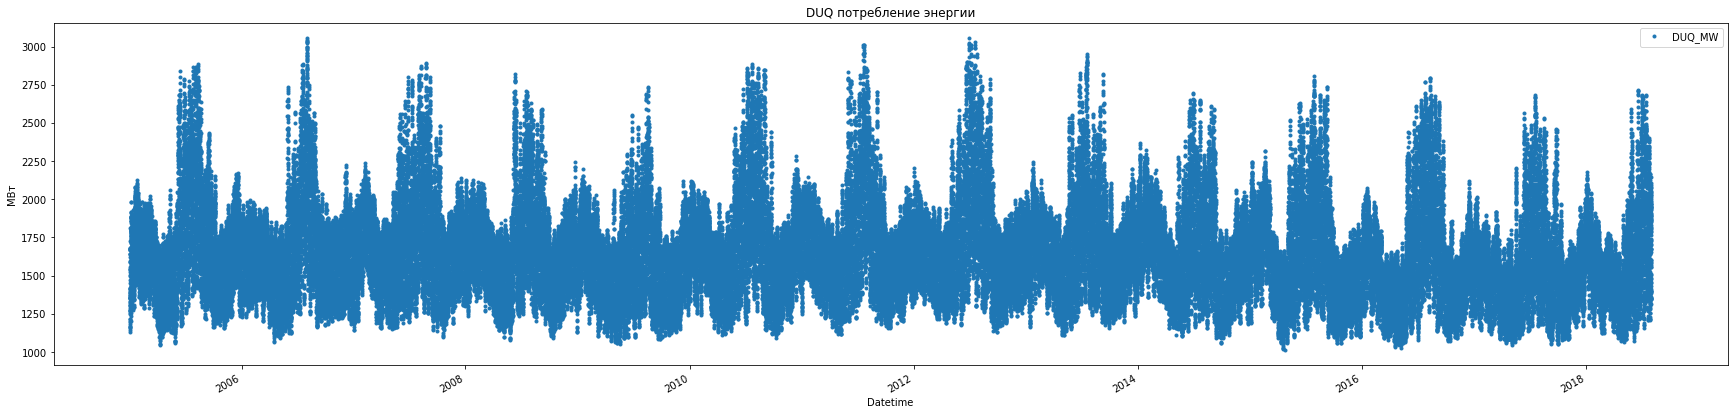

In [8]:
# Отобразим данные графически
data.plot(style='.', figsize=(30, 7), title='DUQ потребление энергии')
plt.ylabel('МВт')

Проверим на уникальность значения индексов, для выявления повторяющихся измерений. Для этого добавим индекс как отдельную колонку.

In [9]:
data['date'] = data.index
print('Число уникальных значений: ',data['date'].unique().shape[0])
print('Число наблюдений: ', data.shape[0])

Число уникальных значений:  119064
Число наблюдений:  119068


Теперь посчитаем повторяющиеся значения в data для колонки 'data'

In [10]:
count_data = data['date'].value_counts()
count_data.head()

2017-11-05 02:00:00    2
2014-11-02 02:00:00    2
2015-11-01 02:00:00    2
2016-11-06 02:00:00    2
2007-07-15 10:00:00    1
Name: date, dtype: int64

Видно, что 4 года подряд в начале ноября однажды вносили данные за день 2 раза. Это очевидно, не верно. Что происходило, следует уточнять у автора данных. В качестве предположения можно подумать о вариантах, например, переход на зимнее время и тогда, в марте -апреле должен быть пропуск. Проверим март-апрель 2014 года.

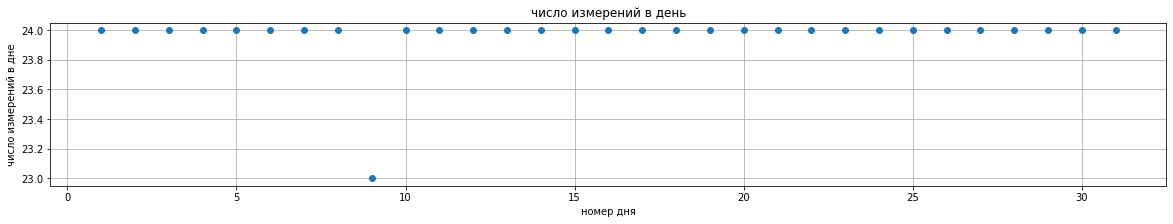

In [11]:
day_H=data['2014-03-01 00:00:00':'2014-03-31 23:00:00'].index.day

plt.figure(figsize=(20,3))
plt.plot(day_H.value_counts().index, day_H.value_counts().values ,'o')

plt.xlabel('номер дня')
plt.ylabel('число измерений в дне')
plt.title('число измерений в день')
plt.grid()
plt.show()

Видим, что один из дней марта имеет меньше измерений, чем остальные. Определим номер этого дня используя подсчет числа измерений по дням и сравнение этой цифры с идеальным значением 24.

In [12]:
Day_count = day_H.value_counts() 
Day_count[Day_count != 24]

9    23
Name: Datetime, dtype: int64

Посмотрим на этот день поближе. После 2-го часа сразу наступил 4-й.

In [13]:
data['2014-03-09 01:00:00':'2014-03-09 06:00:00'].index

DatetimeIndex(['2014-03-09 01:00:00', '2014-03-09 02:00:00',
               '2014-03-09 04:00:00', '2014-03-09 05:00:00',
               '2014-03-09 06:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)

Такой день в марте один - 9 марта 2014. Гипотезу о переходе на летнее(зимнее) время можно считать доказанной.

Подытожим наши результаты. Видим, что данные, в целом, равномерные. Имеют цикличность. Нет каких-то явных отклонений. Можно сказать, что есть небольшое снижение потребления энергии в периоды с 2009 по 2011 и с 2015 до конца наблюдений. Так же в измерениях есть пропуски и дубликаты,  связанные с переходом на зимнее/летнее время.

### 3. Прочитайте базу Brent и сделайте ее перерасчет (ресемплинг) в представление по неделям , по месяцам . Постройте график изменения среднего по выборке и среднего отклонения по выборке на недельных, месячных и годовых группах для Brent. (одна группа на интервале - одно значение std или mean, т.е. если было 28 дней, то 9 значений для ресемплинга на 3 дня, 4 значения при ресемплинге неделя и 2 значения при ресемплинге 2 недели )

In [14]:
brent = pd.read_excel('нефть-brent 2010-2019.xlsx', index_col=[0], parse_dates=[0])

Произведем сортировку по индексу.

In [15]:
brent = brent.sort_index()

Посмотрим примерный вид данных.

In [16]:
brent.head()

,Значение
Дата,
2010-09-01,76.37
2010-09-02,76.89
2010-09-03,76.57
2010-09-04,76.62
2010-09-05,76.63


И на отсутствие пропущенных данных.

In [17]:
brent.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2667 entries, 2010-09-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Значение  2667 non-null   float64
dtypes: float64(1)
memory usage: 41.7 KB


Визуализируем данные до ресемплинга.

Text(0, 0.5, '$')

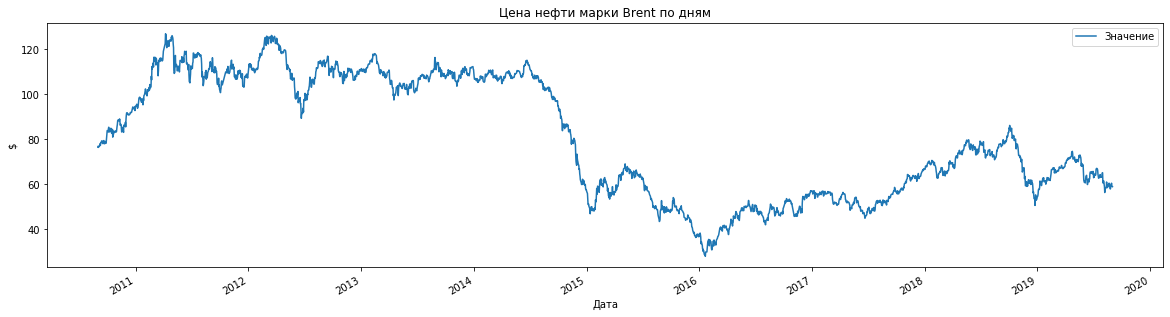

In [18]:
brent.plot(figsize=(20, 5), title='Цена нефти марки Brent по дням')
plt.ylabel('$')

Сделаем ресемплинг по неделям.

In [19]:
brent_w = brent.resample('W').mean().round(2)

Text(0, 0.5, '$')

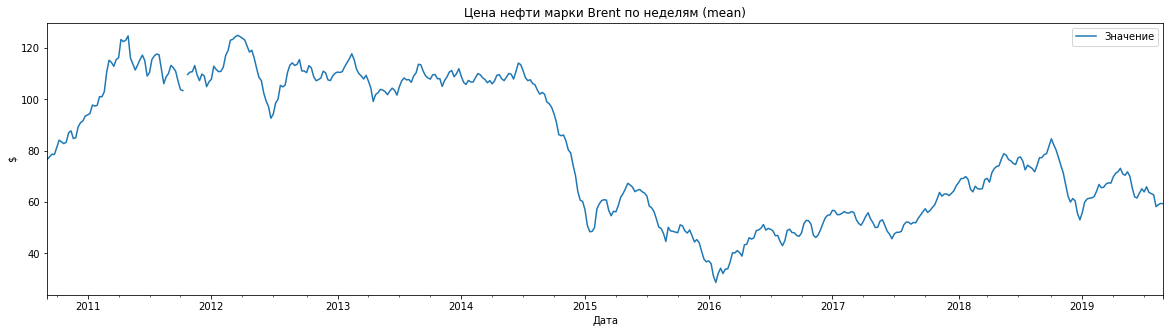

In [20]:
# Построим график для средних значений
brent_w.plot(figsize=(20,5), title='Цена нефти марки Brent по неделям (mean)')
plt.ylabel('$')

In [21]:
brent_w_std = brent.resample('W').std().round(2)

Text(0, 0.5, 'std')

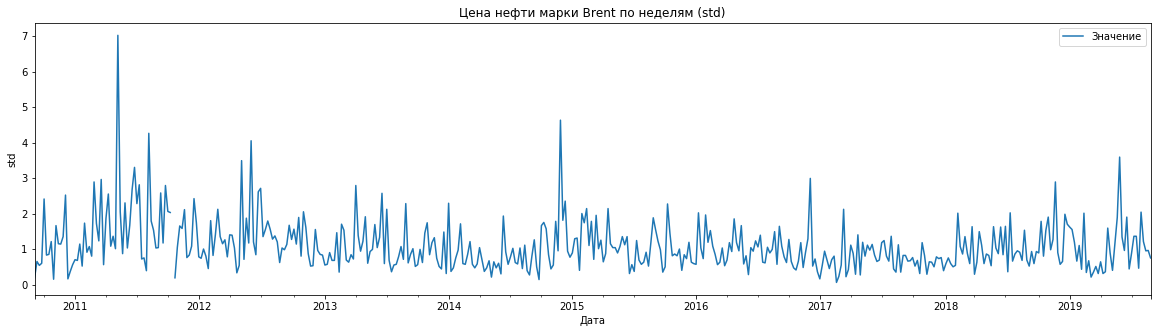

In [22]:
# Построим график для значений отклонений
brent_w_std.plot(figsize=(20,5), title='Цена нефти марки Brent по неделям (std)')
plt.ylabel('std')

Сделаем ресемплинг по месяцам

In [23]:
brent_m = brent.resample('M').mean().round(2)

Text(0, 0.5, '$')

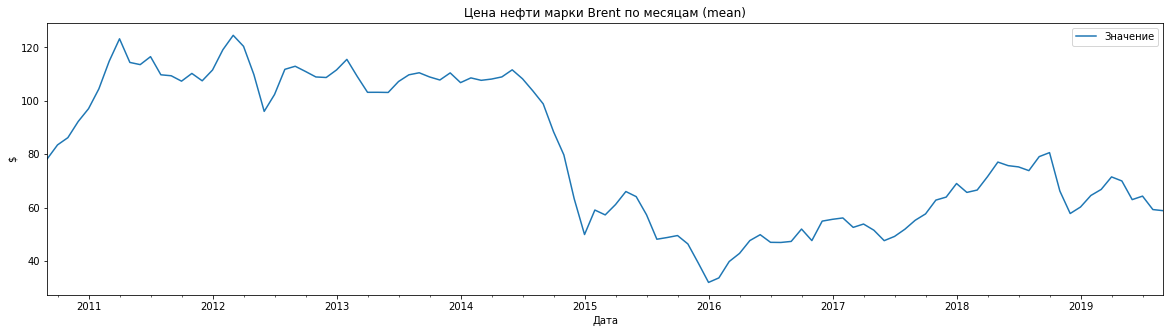

In [24]:
# Построим график для средних значений
brent_m.plot(figsize=(20,5), title='Цена нефти марки Brent по месяцам (mean)')
plt.ylabel('$')

In [25]:
brent_m_std = brent.resample('M').std().round(2)

Text(0, 0.5, 'std')

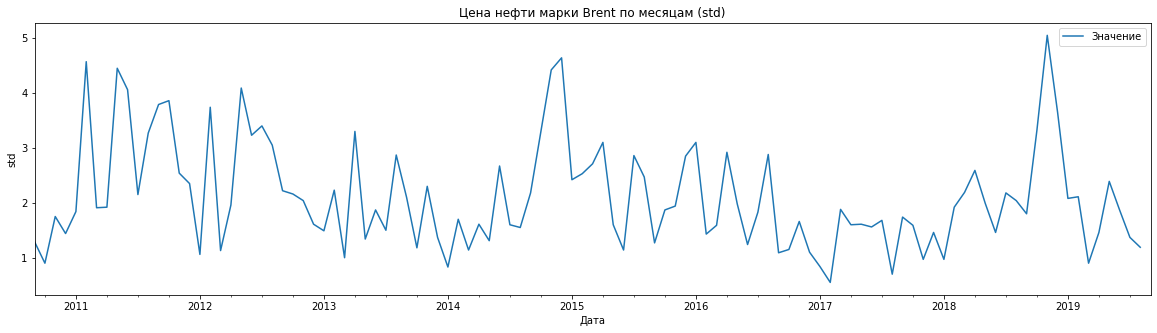

In [26]:
# Построим график для значений отклонений
brent_m_std.plot(figsize=(20,5), title='Цена нефти марки Brent по месяцам (std)')
plt.ylabel('std')

Сделаем ресемплинг по годам

In [27]:
brent_y = brent.resample('Y').mean().round(2)

Text(0, 0.5, '$')

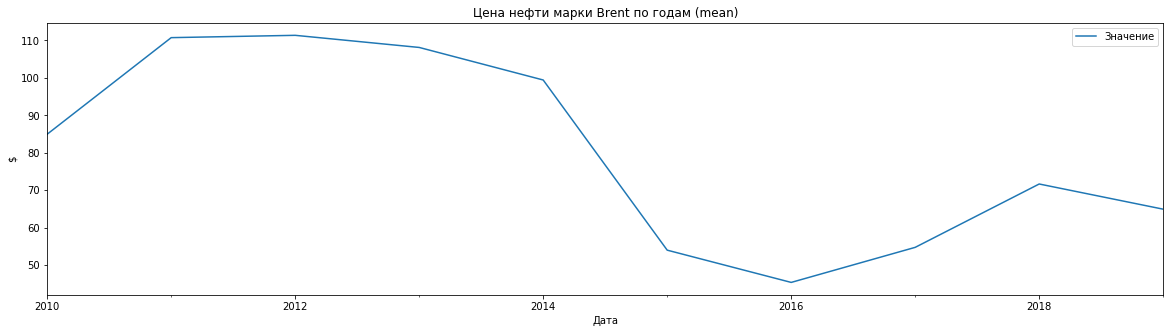

In [28]:
# Построим график для средних значений
brent_y.plot(figsize=(20,5), title='Цена нефти марки Brent по годам (mean)')
plt.ylabel('$')

In [29]:
brent_y_std = brent.resample('Y').std().round(2)

Text(0, 0.5, 'std')

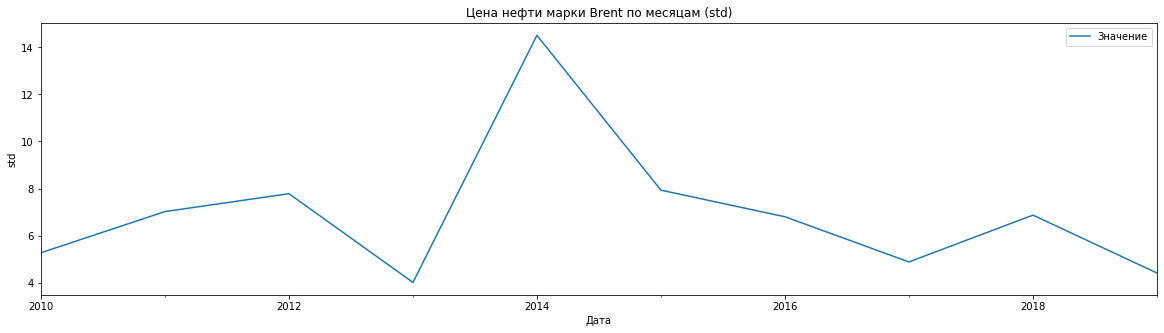

In [30]:
# Построим график для значений отклонений
brent_y_std.plot(figsize=(20,5), title='Цена нефти марки Brent по месяцам (std)')
plt.ylabel('std')

### 4. Сделайте вывод о том, как изменилось поведение цены на недельных и месячных графиках по сравнению с дневными.

Если сравнивать поведение цены на недельном и месячном графиках с дневным, то можно заметить, что график сглаживается, но общая форма сохраняется.